# Modeling - Multiclass

In [44]:
import joblib
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array, to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import os, shutil

np.random.seed(42)

## Establish Image Directories

In [4]:
# location of all image datasets to be split 
input_folder = 'image_datasets/'

Split the images into train, test, and validation sets. 
- 60% Train
- 20% Validation
- 20% Test

In [5]:
# takes in all the image datasets to be split
# puts split images into datasets_split with 60% in train, 20% val, 20% test
splitfolders.ratio(input_folder, output = 'datasets_split',
                   seed = 42, ratio = (0.6, 0.2, 0.2))

Copying files: 6641 files [00:03, 2187.36 files/s]


Define location paths of each split image set. 

In [6]:
X_train = os.path.join('datasets_split/train/')
val_set = os.path.join('datasets_split/val/')
X_test = os.path.join('datasets_split/test/')

In [7]:
# check location
X_test

'datasets_split/test/'

## Preprocessing Images 

- Normalize
- Set up labels for each class


In [8]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     X_train, 
                                                     target_size=(256, 256),
                                                     batch_size=3983) # total in train


val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     val_set, 
                                                     target_size=(256, 256),
                                                     batch_size=1326) # total in val

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     X_test, 
                                                     target_size=(256, 256),
                                                     batch_size=1332) # total in test

Found 3983 images belonging to 7 classes.
Found 1326 images belonging to 7 classes.
Found 1332 images belonging to 7 classes.


Create the labels:

In [9]:
# create the data sets and label the image classes
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [10]:
# check shape of images in train set
train_images.shape

(3983, 256, 256, 3)

In [11]:
# check labels for train
test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
# check what each image is classified as
class_labels = train_generator.class_indices
class_labels

{'baseball_bats': 0,
 'faces': 1,
 'guitar': 2,
 'gun': 3,
 'knives': 4,
 'people': 5,
 'phone': 6}

Label: [0. 0. 0. 1. 0. 0. 0.]


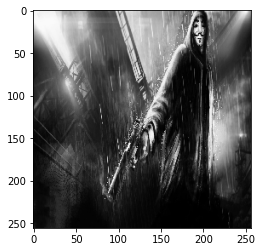

In [13]:
# check an example gun image
sample_train_image = train_images[5]
sample_train_label = train_labels[5]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

Label: [1. 0. 0. 0. 0. 0. 0.]


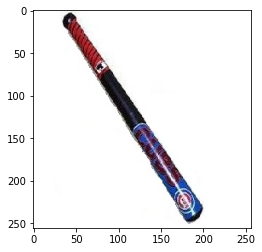

In [14]:
# check an example not gun image
sample_train_image = train_images[52]
sample_train_label = train_labels[52]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

### Visualize the Image Dataset

In [15]:
# function that plots images and labels
def plots(ims, figsize = (20,4), rows = 1, interp = False, titles = None):
    """
    Takes in image set (recommend to slice for large sets); and image labels
    and plots a row of the images with associated labels.
    """
    if type(ims[0]) is np.ndarray:
        ims - np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims - ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 -- 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


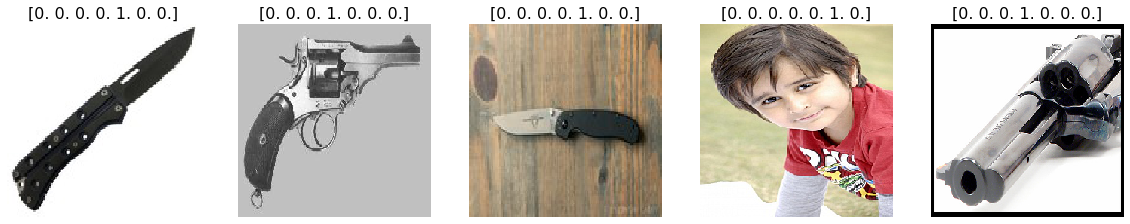

In [16]:
# peek at 5 images in the train set
plots(train_images[10:15], titles = train_labels[10:15])

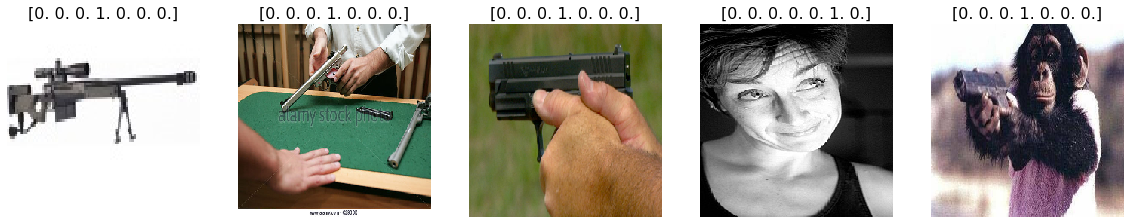

In [17]:
# peek at 5 images in the test set
plots(test_images[10:15], titles = test_labels[10:15])

In [18]:
# Explore dataset again
m_train = train_images.shape[0]  # number of images in train
num_px = train_images.shape[1]  # number of pixels
m_test = test_images.shape[0]  # number of images in test
m_val = val_images.shape[0]  # number of images in validation 

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3983
Number of testing samples: 1332
Number of validation samples: 1326
----------------------------------------
train_images shape: (3983, 256, 256, 3)
train_labels shape: (3983, 7)
----------------------------------------
test_images shape: (1332, 256, 256, 3)
test_labels shape: (1332, 7)
----------------------------------------
val_images shape: (1326, 256, 256, 3)
val_labels shape: (1326, 7)


### Reshaping the images in each set based on number of pixels

In [19]:
# reshapes the images to (num of images in set, num of pixels ie. 256 x 256 x 3 = 196608)
train_img = train_images.reshape(train_images.shape[0], -1) 
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(3983, 196608)
(1332, 196608)
(1326, 196608)


Refine the labels as the y train, validation, and test sets. 

In [20]:
# # reshape the target 
# y_train = np.reshape(train_labels[:,0], (3983,1))
# y_val = np.reshape(val_labels[:,0], (1326,1))
# y_test = np.reshape(test_labels[:,0], (1332,1))

y_train = train_labels
y_val = val_labels
y_test = test_labels

In [21]:
# check
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [22]:
y_test.shape

(1332, 7)

## Build Baseline Dense Network

In [25]:
# Build a baseline fully connected model
np.random.seed(42)

baseline_model = models.Sequential()

baseline_model.add(layers.Dense(128, activation='relu', input_shape=(196608,))) 

# 2 hidden layers
baseline_model.add(layers.Dense(64, activation='relu'))
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(7, activation='softmax')) # 7 different classes; ie. multiclass

In [26]:
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               25165952  
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
Total params: 25,176,519
Trainable params: 25,176,519
Non-trainable params: 0
_________________________________________________________________


In [27]:
# terminate training if doesnt improve on specified min_delta for 5 epochs
trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-5, patience = 5)

**⏰ Below code runs for a few minutes**

In [24]:
baseline_model.compile(optimizer='Adam',
              loss='categorical_crossentropy', # for multiclass classification
              metrics=['accuracy'])

baseline_model = baseline_model.fit(train_img,
                                    y_train,
                                    epochs=50,
                                    batch_size=128,
                                    validation_data=(val_img, y_val),
                                    callbacks=[trainCallback])

Epoch 1/50


2022-08-01 10:14:33.905991: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 10:14:34.246838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 1.9311 - accuracy: 0.5797

2022-08-01 10:14:40.119121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 8s 221ms/step - loss: 1.9311 - accuracy: 0.5797 - val_loss: 2.1897 - val_accuracy: 0.0113
Epoch 2/50
32/32 [==============================] - 6s 201ms/step - loss: 1.9008 - accuracy: 0.5998 - val_loss: 2.1550 - val_accuracy: 0.0158
Epoch 3/50
32/32 [==============================] - 6s 203ms/step - loss: 1.8715 - accuracy: 0.5998 - val_loss: 2.1213 - val_accuracy: 0.0181
Epoch 4/50
32/32 [==============================] - 7s 208ms/step - loss: 1.8431 - accuracy: 0.5998 - val_loss: 2.0891 - val_accuracy: 0.0271
Epoch 5/50
32/32 [==============================] - 7s 209ms/step - loss: 1.8160 - accuracy: 0.5998 - val_loss: 2.0576 - val_accuracy: 0.0415
Epoch 6/50
32/32 [==============================] - 7s 205ms/step - loss: 1.7898 - accuracy: 0.5998 - val_loss: 2.0272 - val_accuracy: 0.0558
Epoch 7/50
32/32 [==============================] - 7s 208ms/step - loss: 1.7645 - accuracy: 0.5998 - val_loss: 1.9978 - val_accuracy: 0.0641
Epoch 8/50
32/32 

### Save the model as a .pkl file 

In [25]:
# # use the built-in open() function to open a file
# output_file = open("baseline_model_multiclass.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(baseline_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://65cfa5ee-3909-4585-9904-e23f02e756f7/assets


In [28]:
# use the built-in open() function again, this time to read
model_file = open("baseline_model_multiclass.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_baseline_model = joblib.load(model_file)
# close the file
model_file.close()

In [30]:
# create a helper function that returns loss and accuracy results from model
# also plots the loss and accuracy 

def model_results(mod, train_img, y_train, test_img, y_test):
    """ Takes in the model, image set, and array y of targets for training and test sets
        and returns the model's loss and accuracy scores.
        Also returns a plot of the training and validation scores. 
    """
    # returns loss and accuracy scores for training and test sets
    results_train = mod.model.evaluate(train_img, y_train)
    results_test = mod.model.evaluate(test_img, y_test)
    
    # get the accuracy and loss for training and validation
    acc = mod.history['accuracy']
    val_acc = mod.history['val_accuracy']
    loss = mod.history['loss']
    val_loss = mod.history['val_loss']
    epochs = range(len(acc))
    
    # return train and test loss and accuracy
    print("Train Results Loss:", round(results_train[0],5))
    print("Train Results Accuracy:", round(results_train[1], 5))
    print("-"* 50)
    print("Test Results Loss:", round(results_test[0],5))
    print("Test Results Accuracy:", round(results_test[1], 5))
    
    # plot the Traininng and Validation Accuracy and Loss
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and Validation accuracy', fontweight = "bold")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation loss', fontweight = "bold")
    plt.ylabel('Categorical Crossentropy Loss')
    plt.legend()
    plt.show()

### Baseline Model Results

2022-08-01 15:13:43.041093: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 15:13:43.297995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 3s 64ms/step - loss: 1.3882 - accuracy: 0.5983
Train Results Loss: 1.28348
Train Results Accuracy: 0.5998
--------------------------------------------------
Test Results Loss: 1.38815
Test Results Accuracy: 0.59835


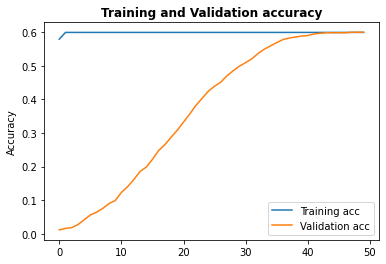

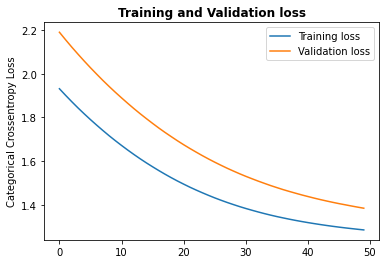

In [31]:
# get baseline model results
model_results(loaded_baseline_model, train_img, y_train, test_img, y_test)

In [111]:
# create helper function to plot test results as a confusion matrix
def get_test_results(mod, test_img, test_y):
    """
    Takes in the model, test image set, and test_y set
    and returns the model's accuracy and confusion matrix.
    """
    # return the loss and accuracy scores for the test set
    mod.model.evaluate(test_img, test_y)
    
    # get probabilites from the prediction on the test image set
    y_proba = mod.model.predict(test_img)
    
    # get assigned index values; ie. predicted labels
    predicted = np.argmax(y_proba, axis= -1)
    predicted
    
    # need to assign the class label to the actual y_test
    y_test_labeled = np.argmax(y_test, axis = -1)
    y_test_labeled

    # plot confusion matrix on test set
    cm = confusion_matrix(y_test_labeled, predicted)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    # get class labels for reference
    print(class_labels)

42/42 [==============================] - 3s 72ms/step


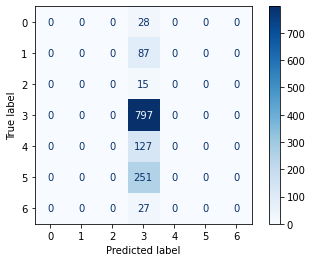

{'baseball_bats': 0, 'faces': 1, 'guitar': 2, 'gun': 3, 'knives': 4, 'people': 5, 'phone': 6}


In [112]:
# get confusion matrix and test results for test image set
get_test_results(loaded_baseline_model, test_img, y_test)